## PyTorch Model Optimization with Opacus

First we construct a PyTorch model.  We're writing these examples as neural networks.  The first example below, however, reduces to the logisitic regression we were using in last weeks DP-SGD example.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ExampleLogisticModule(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        x = self.linear(x)
        x = torch.sigmoid(x)
        return x[:,0]

# class ExampleLogisticModule(nn.Module):
#     def __init__(self, input_size):
#         super().__init__()
#         internal_size = 5
#         self.linear1 = nn.Linear(input_size, internal_size)
#         self.linear2 = nn.Linear(internal_size, 1)
#
#     def forward(self, x):
#         x = self.linear1(x)
#         x = torch.sigmoid(x)
#         x = self.linear2(x)
#         # x = torch.sigmoid(x)
#         return x


Next we load in our data.  We're again using one of our Census PUMS examples, however, switch the variables to predict employment status as a function of education and disability status (it's a stronger relationship than our previous model of marital status).  Note how the dataset is constructed for PyTorch as a pair of tensor objects.

In [2]:
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
data = pd.read_csv(
    "https://raw.githubusercontent.com/privacytoolsproject/cs208/master/data/MaPUMS5full.csv")


# marital ~ educ

dataset = TensorDataset(
    torch.tensor(data[['educ']].values).float(),
    torch.tensor(data['married'].values).float())


Here we show both how to train without preserving privacy (as below), and how to add a privacy-preserving optimizer (commented out) with Opacus.  

We add a "privacy engine" and then assign privacy-preserving parameters to that engine.   This swaps PyTorch's optimizer for a DP optimizer, in this case DP-SGD.  Note the `noise_multiplier` parameter which maps to a standard deviation in the Gaussian mechanism, and the `max_grad_norm` which sets the clipping size.

/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/tmp/ipython-input-3480855826.py:31: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  loss.backward()


Text(0, 0.5, 'loss')

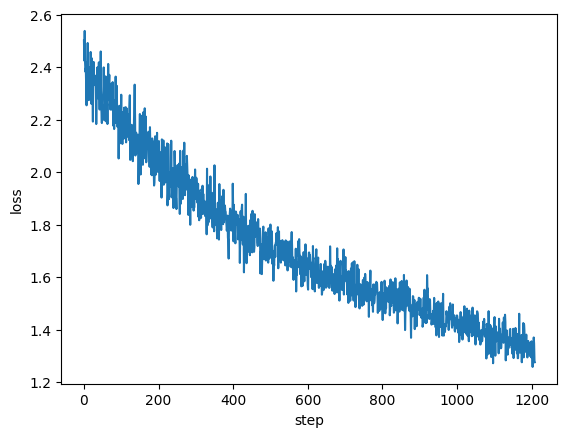

In [4]:
# @title
from opacus import PrivacyEngine

torch.manual_seed(123)

# educ input feature, so input size is now 1
model = ExampleLogisticModule(input_size=1)
data_loader = DataLoader(dataset, batch_size=1_000, shuffle=True)
optimizer = torch.optim.SGD(model.parameters(), lr=.002)
num_epochs = 5

privacy_engine = PrivacyEngine()
model, optimizer, data_loader = privacy_engine.make_private(
     module=model,
     optimizer=optimizer,
     data_loader=data_loader,
     noise_multiplier=1.0, # Gaussian noise level
     max_grad_norm=0.5, # Gradient clipping
)

losses = []


for _ in range(num_epochs):
    for batch in data_loader:

        # set .grad in all parameter tensors
        inputs, targets = batch
        outputs = model(inputs)
        loss = F.binary_cross_entropy(outputs, targets)
        loss.backward()

        # take a step forward
        optimizer.step()

        # clear .grad in all parameter tensors
        optimizer.zero_grad()

        # evaluate performance
        # accuracy = torch.sum(outputs.round() == targets) / len(outputs)
        losses.append(loss.item())

import matplotlib.pyplot as plt
plt.plot(range(len(losses)), losses)
plt.xlabel("step")
plt.ylabel("loss")

In [3]:
!pip install opacus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.4/254.4 kB 6.1 MB/s eta 0:00:00


After you’ve trained your model privately using Opacus, you can query your current privacy budget like this:

In [5]:
privacy_engine.get_epsilon(delta=1e-6)

np.float64(0.9233559198062226)

# 2. Private Model Selection

Now we are training K = 10 differentially private logistic regression models, one for each learning rate. Each model is trained using DP-SGD with Guassian Noise and gradient clipping to ensure privacy gaurentee of δ = 1e-6. This produces privacy guarantee εtraining per model.

This is ran on 5 training epochs for each learning rate, obtaining the the trained private model, average training loss, and the ε value returned.

In [6]:
# K = 10 different private models across a sequence of learning rates
learning_rates = [.001, .002, .003, .004, .005, .006, .007, .008, .009, .01]

K = len(learning_rates)

def dp_model_training(learning_rate):
  model = ExampleLogisticModule(input_size=1)
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  privacy_engine = PrivacyEngine()

  model, optimizer, data_loader_dp = privacy_engine.make_private(
      module=model,
      optimizer=optimizer,
      data_loader=data_loader,
      noise_multiplier=1.0, # Gaussian noise level
      max_grad_norm=0.5, # Gradient clipping
  )

  losses = []
  # Epoch set to 5
  for _ in range(5):
      for bx, by in data_loader_dp:
            outputs = model(bx)
            loss = F.binary_cross_entropy(outputs, by)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())

  eps = privacy_engine.get_epsilon(delta=1e-6)
  return model, np.mean(losses), eps

Now we apply the exponential mechanism with privacy parameter of ε = 1, using a score function equal to the negative average training loss.

First we collect each modes trained weights, average DP-SGD training loss, and privacy ε value returned from training. Next, we convver the loss into a score, then use the exponential mechanism to sample one model. This if followed by returning the selected learning rate, model's score and learned parameters, and total privacy budget.

In [7]:
import math
import numpy as np

models = []
scores = []
epsilons = []

for learning_rate in learning_rates:
    model, avg_loss, eps = dp_model_training(learning_rate)
    models.append(model)
    scores.append(-avg_loss)
    epsilons.append(eps)

    print(f"LR = {learning_rate:.3f} | Avg Loss = {avg_loss:.4f} | ε = {eps:.4f}")

epsilon = 1
sensitivity = 1.0

weights = [math.exp((epsilon * score) / (2 * sensitivity)) for score in scores]
weights = np.array(weights)
weights = weights / weights.sum()

index_selected = np.random.choice(range(K), p=weights)
model_selected = models[index_selected]

print("\nLearning Rate Selected: ", learning_rates[index_selected])
print(f"Model Score (-avg loss): {scores[index_selected]:.4f}")

print(f"\nPrivacy Budget for training (DP-SGD): ε ≈ {eps:.4f}")
print(f"Privacy Budget for selection (Exponential Mechanism): ε = 1")
print(f"Total Privacy Loss: ε ≈ {eps + 1:.4f}  (δ = 1e-6)")

weight = list(model_selected.parameters())[0].item()
bias = list(model_selected.parameters())[1].item()

print("\nSelected Model Parameters")
print(f"Education coefficient (β_educ): {weight:.4f}")
print(f"Intercept (β_0): {bias:.4f}")

print(f"\nModel: P(married = 1 | educ) = sigmoid({weight:.4f} * educ + {bias:.4f})")

/tmp/ipython-input-3303889681.py:25: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  loss.backward()


LR = 0.001 | Avg Loss = 2.2602 | ε = 0.9234
LR = 0.002 | Avg Loss = 1.6269 | ε = 0.9234
LR = 0.003 | Avg Loss = 2.4112 | ε = 0.9234
LR = 0.004 | Avg Loss = 2.2992 | ε = 0.9234
LR = 0.005 | Avg Loss = 1.0422 | ε = 0.9234
LR = 0.006 | Avg Loss = 1.9087 | ε = 0.9234
LR = 0.007 | Avg Loss = 2.1301 | ε = 0.9234
LR = 0.008 | Avg Loss = 1.4267 | ε = 0.9234
LR = 0.009 | Avg Loss = 1.1311 | ε = 0.9234
LR = 0.010 | Avg Loss = 1.2205 | ε = 0.9234

Learning Rate Selected:  0.01
Model Score (-avg loss): -1.2205

Privacy Budget for training (DP-SGD): ε ≈ 0.9234
Privacy Budget for selection (Exponential Mechanism): ε = 1
Total Privacy Loss: ε ≈ 1.9234  (δ = 1e-6)

Selected Model Parameters
Education coefficient (β_educ): 0.2906
Intercept (β_0): -0.8170

Model: P(married = 1 | educ) = sigmoid(0.2906 * educ + -0.8170)


In order to interpret the private logistic regression model selected by the exponential mechanism, we visualize it by comparing the predictions with the observed data. First, we begin by computing the empiral probability of marriage at each education level in the dataset. Next, we generate a range of education values and use the selected model to predict the probability of being married.

Visualizing:

Black scatter points to represent the emperical probabilities

Blue curve to represent the DP logistic regression prediction computed from the selected model

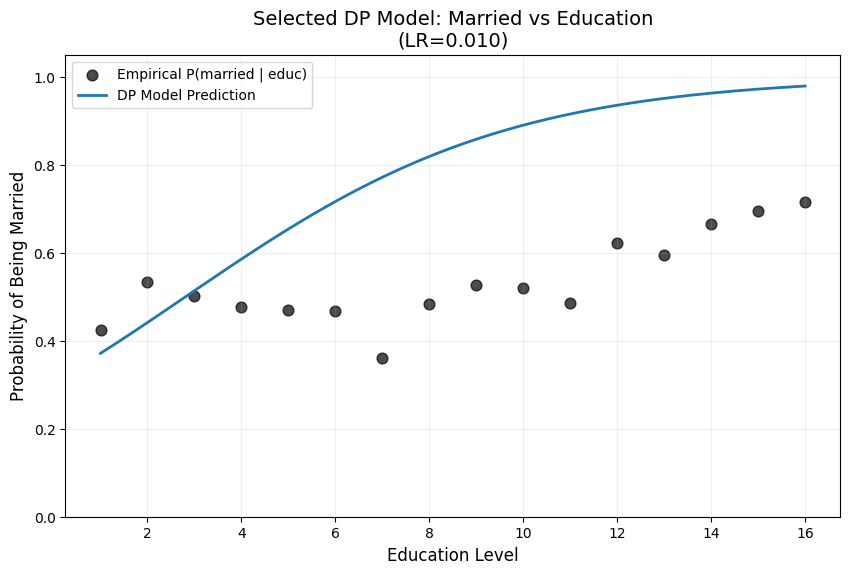

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Education Value Range
educ_range = np.linspace(data['educ'].min(), data['educ'].max(), 200)
educ_tensor = torch.tensor(educ_range.reshape(-1, 1)).float()

# Predictions
model_selected.eval()
with torch.no_grad():
    predictions = model_selected(educ_tensor).numpy()

# Compute empirical probability of marriage at each education level
educ_levels = sorted(data['educ'].unique())
empirical_probs = [data[data['educ'] == level]['married'].mean() for level in educ_levels]

# Plot empirical probability
plt.figure(figsize=(10, 6))
plt.scatter(educ_levels, empirical_probs, s=60, color="black", alpha=0.7, label="Empirical P(married | educ)")

# Selected Model Prediction Plot
plt.plot(educ_range, predictions, linewidth=2, color="tab:blue", label="DP Model Prediction")

plt.xlabel("Education Level", fontsize=12)
plt.ylabel("Probability of Being Married", fontsize=12)
plt.title(f"Selected DP Model: Married vs Education\n(LR={learning_rates[index_selected]:.3f})", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.2)
plt.ylim(0, 1.05)
plt.show()